# NBA Exploration

## Questions

1. What is the minutes distribution of the highest scoring fantasy players?
    * How is it different from players playing a similar range of minutes?
2. How has 3 point shooting changed over time?
    * How has offensive efficiency changed overtime? Does it correspond to the 3 pointer trend?
    * Do teams that take more 3 pointers have more efficient offenses?
3. How has pace of play evolved?
    * Does pace correlate with offensive efficiency?
   
    

In [1]:
#Import packages
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import matplotlib.style as style
pd.set_option('display.max_columns', 50)
%matplotlib inline
style.use('fivethirtyeight')


In [2]:
#import datasets
plyr_logs = pd.read_csv('player_logs_clean.csv', index_col = 0)
team_logs = pd.read_csv('team_logs_full.csv', index_col = 0)

In [3]:
tm_stat_cols = list(team_logs.loc[:,'wl':].columns)
team_avgs = team_logs.groupby(['season','team']).mean()[tm_stat_cols].reset_index()

pl_stat_cols = list(plyr_logs.loc[:,'wl':].columns)
plyr_avgs = plyr_logs.groupby(['season','player_name']).mean()[pl_stat_cols].reset_index()

## 1) What is the minutes distribution of the highest scoring fantasy players?
* How is it different from players playing a similar range of minutes?

count    446596.000000
mean         20.166607
std          14.074122
min          -2.000000
25%           9.000000
50%          18.250000
75%          29.000000
max         103.500000
Name: fscore, dtype: float64


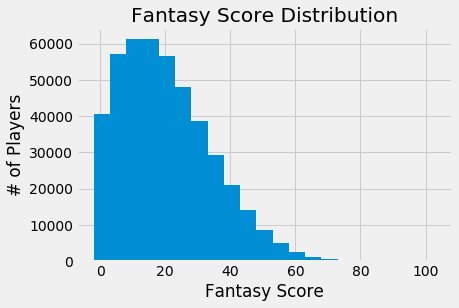

In [4]:
#the fantasy score column will be frequently used
fs = plyr_logs.fscore


#see a quick summary of the fantasy score column of the dataset
print(fs.describe())

#plot a simple histogram to see which increment of fantasy scores appear most
#bins increment by 5 starting from min fscore value
plt.clf()
plt.hist(fs, bins=range(int(min(fs)),int(max(fs)) + 5, 5))
plt.xlabel('Fantasy Score')
plt.ylabel('# of Players')
plt.title('Fantasy Score Distribution')
plt.show()



In [5]:
#filter out top 10 percent of fantasy scores
top5pct = plyr_logs.loc[fs > fs.quantile(.95)]
stat_cols = ['mp', 'fgm', 'fga',
       'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta', 'ft_pct', 'oreb',
       'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','fscore']
top5pct[stat_cols].describe()

,mp,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,fscore
count,22228.000000,22228.000000,22228.000000,22228.000000,22228.000000,22228.000000,22228.00000,22228.000000,22228.000000,22228.000000,22228.000000,22228.000000,22228.000000,22228.000000,22228.000000,22228.000000,22228.000000,22228.000000,22228.000000,22228.000000
mean,39.350279,9.800747,18.757198,0.533016,1.625652,3.691740,0.29967,5.811769,7.322071,0.767209,2.370569,7.107207,9.477776,5.732140,1.747616,1.233489,2.657684,2.617869,27.038915,53.959106
std,4.892798,2.887838,5.256487,0.119160,1.875675,3.495994,0.29864,3.681012,4.378159,0.243387,2.178276,3.562586,4.732889,3.841703,1.440285,1.529721,1.796458,1.420945,7.453409,6.841339
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,46.500000
25%,36.000000,8.000000,15.000000,0.452000,0.000000,0.000000,0.00000,3.000000,4.000000,0.667000,1.000000,4.000000,6.000000,3.000000,1.000000,0.000000,1.000000,2.000000,22.000000,48.750000
50%,39.000000,10.000000,18.000000,0.526000,1.000000,3.000000,0.28600,5.000000,7.000000,0.818000,2.000000,7.000000,9.000000,5.000000,2.000000,1.000000,2.000000,3.000000,27.000000,52.000000
75%,43.000000,12.000000,22.000000,0.609000,3.000000,6.000000,0.50000,8.000000,10.000000,1.000000,4.000000,9.000000,13.000000,8.000000,3.000000,2.000000,4.000000,4.000000,32.000000,57.062500
max,63.000000,28.000000,50.000000,1.000000,13.000000,22.000000,1.00000,25.000000,39.000000,1.000000,18.000000,25.000000,31.000000,25.000000,10.000000,12.000000,12.000000,6.000000,81.000000,103.500000


The minimum minutes played whould not be 0 minutes for anyone in this dataset. Let's see what's going on there.

In [6]:
missing_minutes_top5 = top5pct.loc[top5pct.mp == 0]
missing_minutes_top5

,game_date,year,month,day,season_id,season,player_id,player_name,team_id,team_abbreviation,team_name,team,opp,game_id,home,matchup,wl,mp,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,fscore,ast_pct,blk_pct,dreb_pct,oreb_pct,reb_pct,stl_pct,tov_pct,efg_pct,ts_pct,usg_pct
152140,2006-12-13,2006,12,13,22006,2006,2546,Carmelo Anthony,1610612743,DEN,Denver Nuggets,DEN,WAS,20600314,0,DEN @ WAS,0,0,16,27,0.593,0,0,0.00,5,6,0.833,5,3,8.0,4,2,0,2,4,37,-24,56.00,-25.0,NaN,inf,inf,inf,inf,6.321113,0.592593,0.624157,inf
152223,2006-12-13,2006,12,13,22006,2006,2240,Gilbert Arenas,1610612764,WAS,Washington Wizards,WAS,DEN,20600314,1,WAS vs. DEN,1,0,10,21,0.476,3,12,0.25,11,12,0.917,0,4,4.0,5,4,0,3,2,34,31,54.50,-50.0,NaN,inf,NaN,inf,inf,10.245902,0.547619,0.646880,inf
152342,2006-12-13,2006,12,13,22006,2006,2406,Caron Butler,1610612764,WAS,Washington Wizards,WAS,DEN,20600314,1,WAS vs. DEN,1,0,10,20,0.500,0,3,0.00,6,6,1.000,1,8,9.0,7,1,0,1,3,26,26,49.25,-70.0,NaN,inf,inf,inf,inf,4.230118,0.500000,0.574205,inf
154775,2006-12-30,2006,12,30,22006,2006,2200,Pau Gasol,1610612763,MEM,Memphis Grizzlies,MEM,TOR,20600445,1,MEM vs. TOR,1,0,8,16,0.500,0,0,0.00,6,7,0.857,1,10,11.0,4,1,2,3,1,22,11,47.75,-50.0,inf,inf,inf,inf,inf,13.586957,0.500000,0.576520,inf


There are 4 players in the top5pct dataset with 0 minutes played but registered stats. We should check the full player logs dataset for the same issue as well.

In [7]:
#filter out all players with no mintues played and a nonzero fantasy score, or a 0 fantasy score with turnovers
missing_minutes = plyr_logs.loc[(plyr_logs.mp == 0) & ((fs!=0) | ((fs==0) & (plyr_logs.tov!=0)))]
missing_minutes = missing_minutes.sort_values('fscore', ascending = False)
missing_minutes.head(10)

,game_date,year,month,day,season_id,season,player_id,player_name,team_id,team_abbreviation,team_name,team,opp,game_id,home,matchup,wl,mp,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,fscore,ast_pct,blk_pct,dreb_pct,oreb_pct,reb_pct,stl_pct,tov_pct,efg_pct,ts_pct,usg_pct
152140,2006-12-13,2006,12,13,22006,2006,2546,Carmelo Anthony,1610612743,DEN,Denver Nuggets,DEN,WAS,20600314,0,DEN @ WAS,0,0,16,27,0.593,0,0,0.000,5,6,0.833,5,3,8.0,4,2,0,2,4,37,-24,56.00,-25.000000,NaN,inf,inf,inf,inf,6.321113,0.592593,0.624157,inf
152223,2006-12-13,2006,12,13,22006,2006,2240,Gilbert Arenas,1610612764,WAS,Washington Wizards,WAS,DEN,20600314,1,WAS vs. DEN,1,0,10,21,0.476,3,12,0.250,11,12,0.917,0,4,4.0,5,4,0,3,2,34,31,54.50,-50.000000,NaN,inf,NaN,inf,inf,10.245902,0.547619,0.646880,inf
152342,2006-12-13,2006,12,13,22006,2006,2406,Caron Butler,1610612764,WAS,Washington Wizards,WAS,DEN,20600314,1,WAS vs. DEN,1,0,10,20,0.500,0,3,0.000,6,6,1.000,1,8,9.0,7,1,0,1,3,26,26,49.25,-70.000000,NaN,inf,inf,inf,inf,4.230118,0.500000,0.574205,inf
154775,2006-12-30,2006,12,30,22006,2006,2200,Pau Gasol,1610612763,MEM,Memphis Grizzlies,MEM,TOR,20600445,1,MEM vs. TOR,1,0,8,16,0.500,0,0,0.000,6,7,0.857,1,10,11.0,4,1,2,3,1,22,11,47.75,-50.000000,inf,inf,inf,inf,inf,13.586957,0.500000,0.576520,inf
152347,2006-12-13,2006,12,13,22006,2006,2217,Brendan Haywood,1610612764,WAS,Washington Wizards,WAS,DEN,20600314,1,WAS vs. DEN,1,0,4,5,0.800,0,0,0.000,4,6,0.667,5,8,13.0,3,1,2,1,4,12,22,39.75,-75.000000,inf,inf,inf,inf,inf,11.574074,0.800000,0.785340,inf
154825,2006-12-30,2006,12,30,22006,2006,2031,Stromile Swift,1610612763,MEM,Memphis Grizzlies,MEM,TOR,20600445,1,MEM vs. TOR,1,0,5,10,0.500,0,0,0.000,5,5,1.000,4,10,14.0,0,1,2,4,2,15,11,38.00,-0.000000,inf,inf,inf,inf,inf,24.691358,0.500000,0.614754,inf
154856,2006-12-30,2006,12,30,22006,2006,2034,Mike Miller,1610612763,MEM,Memphis Grizzlies,MEM,TOR,20600445,1,MEM vs. TOR,1,0,9,15,0.600,7,12,0.583,2,2,1.000,2,2,4.0,1,1,0,3,3,27,4,37.50,-11.111111,NaN,inf,inf,inf,inf,15.889831,0.833333,0.850126,inf
154762,2006-12-30,2006,12,30,22006,2006,1088,Chucky Atkins,1610612763,MEM,Memphis Grizzlies,MEM,TOR,20600445,1,MEM vs. TOR,1,0,4,10,0.400,2,5,0.400,6,7,0.857,0,2,2.0,9,2,0,2,2,16,17,36.00,-225.000000,NaN,inf,NaN,inf,inf,13.262599,0.500000,0.611621,inf
152292,2006-12-13,2006,12,13,22006,2006,948,Marcus Camby,1610612743,DEN,Denver Nuggets,DEN,WAS,20600314,0,DEN @ WAS,0,0,6,7,0.857,0,0,0.000,0,0,0.000,0,7,7.0,3,1,2,3,3,12,-13,29.75,-50.000000,inf,inf,NaN,inf,inf,30.000000,0.857143,0.857143,inf
154830,2006-12-30,2006,12,30,22006,2006,1725,Rasho Nesterovic,1610612761,TOR,Toronto Raptors,TOR,MEM,20600445,0,TOR @ MEM,0,0,6,10,0.600,0,0,0.000,1,2,0.500,3,6,9.0,2,0,1,1,4,13,-11,28.75,-33.333333,inf,inf,inf,inf,NaN,8.417508,0.600000,0.597426,inf


There are 205 rows where players registered box score stats and appear to have played no minutes. It seems as though many of these players had minimal impacts to the game, which could mean they're minutes played was rounded down to 0. There are quite a few players with actual playing time that are missing minutes. Lets just place the average minutes of each player for the season as the value for that game.

In [8]:
avg_minutes = plyr_logs.groupby(['season','player_name']).mp.mean()
for i in missing_minutes.index:
    plyr = str(plyr_logs.loc[i,'player_name'])
    szn = int(plyr_logs.loc[i,'season'])
    avg = avg_minutes[szn][plyr]
    plyr_logs.loc[i,'mp'] = int(round(avg,0))                                                                            

missing_minutes = plyr_logs.loc[(plyr_logs.mp == 0) & ((fs!=0) | ((fs==0) & (plyr_logs.tov!=0)))]
missing_minutes

,game_date,year,month,day,season_id,season,player_id,player_name,team_id,team_abbreviation,team_name,team,opp,game_id,home,matchup,wl,mp,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,fscore,ast_pct,blk_pct,dreb_pct,oreb_pct,reb_pct,stl_pct,tov_pct,efg_pct,ts_pct,usg_pct
302786,2013-01-15,2013,1,15,22012,2012,202345,Damion James,1610612751,BKN,Brooklyn Nets,BKN,TOR,21200566,1,BKN vs. TOR,1,0,0,0,0.0,0,0,0.0,0,0,0.0,0,1,1.0,0,0,0,0,0,0,0,1.25,NaN,NaN,inf,NaN,inf,NaN,NaN,NaN,NaN,NaN


In [9]:
# only one player had a season average in minutes played that rounded to 0, assign him 1 minute for that game
plyr_logs.loc[missing_minutes.index[0],'mp'] = 1  

top5pct = plyr_logs.loc[fs > fs.quantile(.95)]


### Analyze Minutes Played

The average minutes played for the top 5 percent of fantasy scores is 38.3 minutes. This is a very high minutes total, and would lead the league if averaged over an entire season for some years. Let's see what average number of minutes led the league in the past 10 years. 

In [10]:
#groupby season and player and average the minutes column. Return the season and max average minutes value. Only consider
#players who played over 20 games in a season
ave_mins = plyr_logs.groupby(['season','player_name'])['mp'].agg(['mean','count']).reset_index()
ave_mins = ave_mins.loc[ave_mins['count'] > 20]
ave_mins.groupby('season')['mean'].max()

season
2000    42.000000
2001    43.750000
2002    42.548780
2003    42.541667
2004    42.350000
2005    43.055556
2006    42.400000
2007    41.804878
2008    39.829268
2009    41.359375
2010    40.350000
2011    39.462963
2012    38.692308
2013    38.701493
2014    38.692308
2015    38.060976
2016    37.783784
2017    36.878049
Name: mean, dtype: float64

As you can see, 38.3 minutes would have led the league the past 3 years. Interestingly enough, amount of minutes played it took to lead the league seems to have decreased over the past 10 years. If fantasy scores tend to increase with minutes played, this could mean that the top fantasy scores over the past 10 years have decreased. Lets compare the minutes played to the fantasy score.

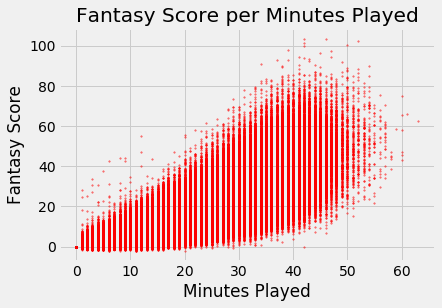

In [11]:
plt.clf()
plt.scatter(plyr_logs.mp, plyr_logs.fscore, marker = '.',s = 10, c='red', alpha = .5)
plt.xlabel('Minutes Played')
plt.ylabel('Fantasy Score')
plt.title('Fantasy Score per Minutes Played')
plt.show()

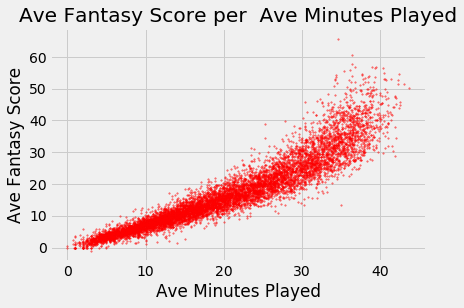

In [12]:
plt.clf()
plt.scatter(plyr_avgs.mp, plyr_avgs.fscore, marker = '.',s = 10, c='red', alpha = .5)
plt.xlabel('Ave Minutes Played')
plt.ylabel('Ave Fantasy Score')
plt.title('Ave Fantasy Score per  Ave Minutes Played')
plt.show()

Clearly there is a strong positive correlation between minutes played and fantasy score when the entire league is considered. How does the distribution change if we only look at the top 5 percent of fantasy scores?


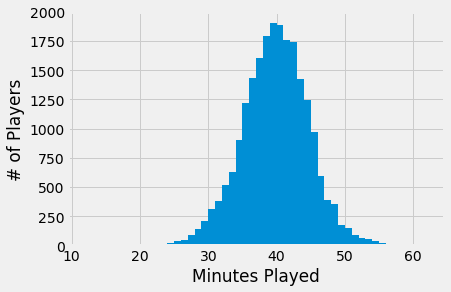

In [13]:
#The minutes distribution of the top 5 percent of fantasy scores
plt.clf()
plt.hist(top5pct.mp,bins=range(min(top5pct.mp),max(top5pct.mp)))
plt.xlabel('Minutes Played')
plt.ylabel('# of Players')
plt.show()

This last histogram is very interesting. The minutes played among the top 5 percent of fantasy scores seems to be normally distributed. We will not be doing a normalcy test here, but this would be a fun exercise as well. Let's instead compare of the average scores of the top players compare to those who played a similiar number of minutes. 

However, the scale seems to start around 10 minutes, which is a very low number of minutes played to score. Lets see who these outliers are.

In [14]:
top5pct.sort_values('mp').head(15)

,game_date,year,month,day,season_id,season,player_id,player_name,team_id,team_abbreviation,team_name,team,opp,game_id,home,matchup,wl,mp,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,fscore,ast_pct,blk_pct,dreb_pct,oreb_pct,reb_pct,stl_pct,tov_pct,efg_pct,ts_pct,usg_pct
143879,2006-04-09,2006,4,9,22005,2005,1495,Tim Duncan,1610612759,SAS,San Antonio Spurs,SAS,MEM,20501143,1,SAS vs. MEM,1,12,8,14,0.571,0,0,0.000,7,12,0.583,3,9,12.0,5,2,3,4,3,23,7,55.00,32.110092,7.118644,30.731707,10.243902,20.487805,3.321471,17.182131,0.571429,0.596473,34.020877
148212,2006-11-17,2006,11,17,22006,2006,1718,Paul Pierce,1610612738,BOS,Boston Celtics,BOS,POR,20600120,1,BOS vs. POR,1,12,10,19,0.526,4,6,0.667,5,6,0.833,0,6,6.0,2,2,1,1,1,29,14,47.00,27.272727,4.017857,35.526316,0.000000,17.763158,4.887837,4.416961,0.631579,0.670055,50.019639
435498,2018-01-24,2018,1,24,22017,2017,1627832,Fred VanVleet,1610612761,TOR,Toronto Raptors,TOR,ATL,21700705,0,TOR @ ATL,1,18,6,9,0.667,4,6,0.667,3,3,1.000,1,6,7.0,5,2,3,0,2,19,13,47.25,57.562620,15.031447,30.641026,5.106838,17.873932,5.123892,0.000000,0.888889,0.920543,23.423362
201627,2008-12-06,2008,12,6,22008,2008,1495,Tim Duncan,1610612759,SAS,San Antonio Spurs,SAS,GSW,20800294,1,SAS vs. GSW,1,20,7,10,0.700,0,0,0.000,6,9,0.667,5,8,13.0,5,1,0,0,4,20,35,47.25,39.478031,0.000000,38.240000,23.900000,31.070000,2.477505,0.000000,0.700000,0.716332,31.607048
152772,2006-12-16,2006,12,16,22006,2006,948,Marcus Camby,1610612743,DEN,Denver Nuggets,DEN,NYK,20600344,0,DEN @ NYK,1,20,9,11,0.818,0,0,0.000,6,6,1.000,1,8,9.0,3,1,7,0,1,24,16,55.75,14.285714,15.909091,30.769231,3.846154,17.307692,1.560266,0.000000,0.818182,0.879765,19.530355
335344,2014-03-04,2014,3,4,22013,2013,201566,Russell Westbrook,1610612760,OKC,Oklahoma City Thunder,OKC,PHI,21300901,1,OKC vs. PHI,1,20,4,9,0.444,1,3,0.333,4,4,1.000,1,9,10.0,14,3,0,6,2,13,25,54.50,100.598802,0.000000,37.894737,4.210526,21.052632,6.567861,35.799523,0.500000,0.604089,34.403011
446471,2018-04-11,2018,4,11,22017,2017,203382,Aron Baynes,1610612738,BOS,Boston Celtics,BOS,BKN,21701219,1,BOS vs. BKN,1,20,12,23,0.522,0,1,0.000,2,2,1.000,9,5,14.0,2,0,0,1,1,26,22,47.50,27.906977,0.000000,19.354839,34.838710,27.096774,0.000000,4.019293,0.521739,0.544389,49.105263
413037,2017-02-26,2017,2,26,22016,2016,202326,DeMarcus Cousins,1610612740,NOP,New Orleans Pelicans,NOP,OKC,21600880,0,NOP @ OKC,0,21,8,15,0.533,0,3,0.000,15,15,1.000,2,8,10.0,3,0,0,1,6,31,2,49.00,38.383298,0.000000,52.027211,13.006803,32.517007,0.000000,4.424779,0.533333,0.717593,48.402244
207964,2009-01-20,2009,1,20,22008,2008,1938,Manu Ginobili,1610612759,SAS,San Antonio Spurs,SAS,IND,20800614,1,SAS vs. IND,1,21,8,10,0.800,4,4,1.000,6,7,0.857,0,8,8.0,3,2,1,2,0,26,26,47.50,37.249872,3.292517,32.347536,0.000000,16.173768,4.925591,13.262599,1.000000,0.993884,31.886064
267051,2011-03-25,2011,3,25,22010,2010,2365,Chris Andersen,1610612743,DEN,Denver Nuggets,DEN,WAS,21001076,1,DEN vs. WAS,1,21,7,7,1.000,0,0,0.000,3,4,0.750,2,9,11.0,1,2,5,0,2,17,20,47.75,8.791209,19.370460,45.714286,10.158730,27.936508,4.849636,0.000000,1.000000,0.970320,18.110399


Tim Duncan and Paul Pierce are 2 of the best players in the game, but 12 minutes seems a bit off here. I went to Basketballreference.com to cross check, an Duncan actually played 38 minutes and Pierce played 31 minutes on those dates. I doubled checked a few of the other like Fred VanVleet scoring 47.25 fantasy points in 18 minutes as well as Aaron Baynes and his performance against BKN. They all seem to check out. This does leave some room for concern that a a small portion of stats may be innacurate, but manually checking each one will be too time consuming, and they shouldn't change the practicality of any results.

In [15]:
# change the minutes of Tim Duncan and Paul Pierce for the games discussed
plyr_logs.loc[143879,'mp'] = 38
plyr_logs.loc[148212,'mp'] = 31
top5pct = plyr_logs.loc[fs > fs.quantile(.95)]

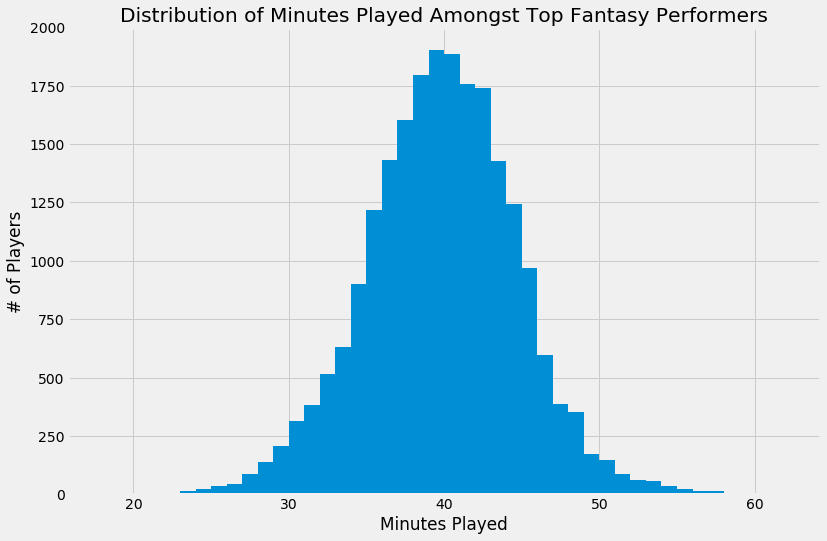

In [16]:
#The minutes distribution of the top 5 percent of fantasy scores
plt.clf()
plt.figure(figsize = (12,8))
plt.hist(top5pct.mp,bins=range(min(top5pct.mp),max(top5pct.mp)))
plt.xlabel('Minutes Played')
plt.ylabel('# of Players')
plt.title('Distribution of Minutes Played Amongst Top Fantasy Performers')
plt.show()

In [17]:
#calculate the minutes played 2 standards of deviation under the average
sig2 = top5pct.mp.mean() - top5pct.mp.std() * 2
sig2

29.64348563795832

In [18]:
#see percentage of players in top5pct that played more 
top5pct.mp.loc[top5pct.mp >= sig2].count() / top5pct.mp.count()

0.97507648011517001

In [19]:
sig_mins = plyr_logs.loc[plyr_logs.mp >= sig2]

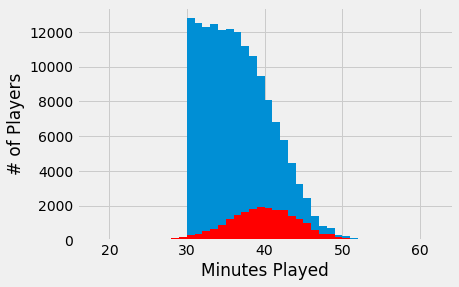

In [20]:
plt.clf()
plt.hist(sig_mins.mp,bins=range(min(sig_mins.mp),max(sig_mins.mp)))
plt.hist(top5pct.mp,bins=range(min(top5pct.mp),max(top5pct.mp)), color='red')
plt.xlabel('Minutes Played')
plt.ylabel('# of Players')
plt.show()

In [21]:
pct_top5_40min = (top5pct.fscore.loc[top5pct.mp > 40].count() / sig_mins.fscore.loc[sig_mins.mp > 40].count())*100
print(str(round(pct_top5_40min,2))+'% of players who play over 40 minutes in a game attain a fantasy score in the top 5 percentile of all players')

33.95% of players who play over 40 minutes in a game attain a fantasy score in the top 5 percentile of all players


### Conclusion

There is no surprise here, the number of players that play more than ~29 minutes is greatest at 29 minutes and decreases as more and more minutes are played. What is interesting is the 38 minutes peak point of the top players. Thinking about it intuitively, the less minutes played, the less time to score stats. Looking at the other end of the distribution, we can see that less and less players actually play over 45 minutes a game, so the decline is natural on that end as well. The proportion of players who played big minutes to those who scored higher also goes up. While box score stats are obviously directly correlated to a players fantasy score, the likelihood of a player to play over 40 minutes can be a big indicator of whether or not they will be a top fantasy scorer as well. 


## 2) How has 3 point shooting changed over time?
* How has offensive efficiency changed overtime? Does it correspond to the 3 pointer trend?
* Do teams that take more 3 pointers have more efficient offenses?

### Analyzing Trends

If you're a basketball fan, you might be familiar with the fact that teams are shooting a lot more 3 pointers now than they did in past seasons. But how pronounced is the difference? Let's dig into the data by looking at the distribution of the number of 3 pointers attempted in the 2000-01 season compared to the most recent 2017-18 season. 

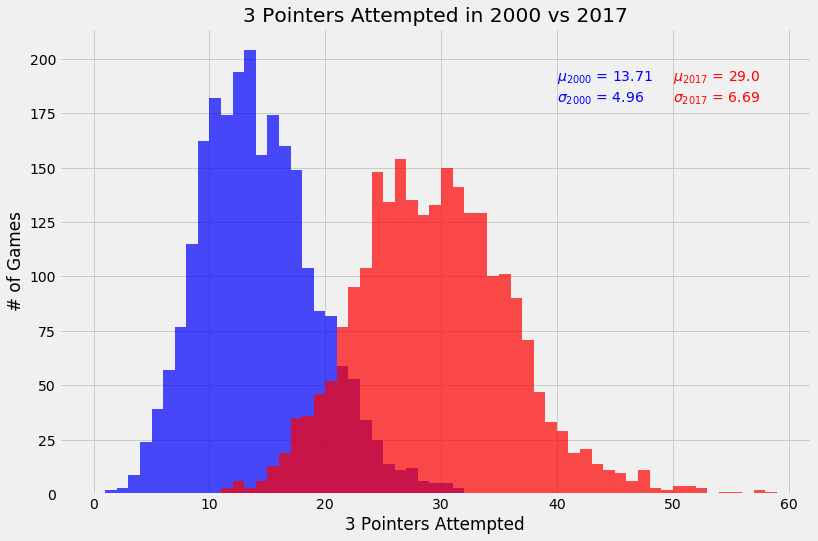

In [23]:
def season_stats(data,season):
    """Return the data relevant to a particular season"""
    return data.loc[data.season == season]

tm_logs_00 = season_stats(team_logs,2000)
tm_logs_17 = season_stats(team_logs,2017)

mean_fg3a_00 = tm_logs_00.fg3a.mean()
mean_fg3a_17 = tm_logs_17.fg3a.mean()

std_fg3a_00 = tm_logs_00.fg3a.std()
std_fg3a_17 = tm_logs_17.fg3a.std()

plt.clf()
plt.figure(figsize=(12,8))
plt.hist(tm_logs_00.fg3a, bins=range(0,60), color = 'blue', alpha = .7)
plt.hist(tm_logs_17.fg3a, bins=range(0,60), color = 'red', alpha = .7)
plt.text(x=40, y = 190, s =r'$\mu_{2000}$ = '+str(round(mean_fg3a_00,2)), color = 'blue')
plt.text(x=40, y = 180, s =r'$\sigma_{2000}$ = '+str(round(std_fg3a_00,2)), color = 'blue')
plt.text(x=50, y = 190, s =r'$\mu_{2017}$ = '+str(round(mean_fg3a_17,2)), color = 'red')
plt.text(x=50, y = 180, s =r'$\sigma_{2017}$ = '+str(round(std_fg3a_17,2)), color = 'red')
plt.xlabel('3 Pointers Attempted')
plt.ylabel('# of Games')
plt.title('3 Pointers Attempted in 2000 vs 2017')
plt.show()


#### Significant difference

The distributions seen above do a great job of highlighting the drastic change in the amount of 3 pointers taken at the start of the century and now. The average amount of 3 pointers in a game has more than doubled from 13.71 attempts to to 29 attempts a game. We can also see that there is a larger spread now on a game to game basis.  The most interesting thing is the maximum number of threes attempted in a game in 2000 seems to be around 32-33 attempts, while that is closer the the average in todays game. Lets investigate this a bit further.

#### Create Tables for Team Averages and League Averages

In [24]:
stat_cols = ['mp', 'fgm', 'fga','fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 
             'ftm', 'fta', 'ft_pct', 'oreb','dreb', 'reb', 'ast', 'stl', 
             'blk', 'tov', 'pf', 'pts', 'plus_minus', 'fscore', 'possessions','pace','off_eff']
team_avgs = team_logs.groupby(['season','team'])[stat_cols].mean().reset_index()
league_avgs = team_avgs.groupby('season')[stat_cols].mean().reset_index()

team_avgs.head()

,season,team,mp,fgm,fga,fg_pct,fg3m,fg3a,fg3_pct,ftm,fta,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,pts,plus_minus,fscore,possessions,pace,off_eff
0,2000,ATL,240.609756,35.073171,81.317073,0.431305,4.060976,11.378049,0.359317,16.756098,22.085366,0.765671,12.536585,30.365854,42.902439,19.012195,7.731707,4.719512,16.682927,22.719512,90.963415,-5.207317,196.164634,92.563862,91.964603,98.331064
1,2000,BKN,240.609756,33.914634,79.878049,0.424195,4.402439,13.219512,0.325049,19.865854,26.170732,0.761171,11.085366,28.500000,39.585366,19.548780,7.914634,4.963415,14.731707,24.170732,92.097561,-5.048780,195.993902,92.410336,91.821171,99.645696
2,2000,BOS,241.829268,33.817073,79.085366,0.428549,7.219512,19.914634,0.356805,19.768293,26.707317,0.736402,10.939024,28.865854,39.804878,20.829268,9.378049,4.097561,15.670732,23.804878,94.621951,-2.134146,202.847561,93.162640,92.552747,101.674433
3,2000,CHA,242.439024,34.146341,79.280488,0.432915,4.146341,12.000000,0.340244,19.500000,26.170732,0.743256,12.597561,31.804878,44.402439,23.170732,8.109756,5.548780,14.426829,21.378049,91.939024,2.097561,208.875000,89.798869,89.465060,102.406031
4,2000,CHI,242.134146,33.182927,78.182927,0.425561,4.012195,11.585366,0.347720,17.195122,23.280488,0.736854,11.292683,27.560976,38.853659,22.073171,8.231707,4.621951,15.756098,23.195122,87.573171,-9.097561,193.585366,90.406120,89.379496,96.903257


In [25]:
#Table of minimum and maximum number of 3s averaged by a team each season
threes_min_max = team_avgs.groupby(['season']).agg(['min','max']).fg3a.reset_index()
threes_min_max

,season,min,max
0,2000,8.036585,19.914634
1,2001,8.719512,23.731707
2,2002,7.817073,26.280488
3,2003,9.585366,23.609756
4,2004,8.158537,24.707317
5,2005,9.707317,25.573171
6,2006,10.036585,23.987805
7,2007,11.451220,26.646341
8,2008,11.573171,27.853659
9,2009,12.439024,27.329268


#### Visualize the table
In the table above we can see that the minimum amount of 3 pointers averaged in 2017-18 and even in 2016-17, is greater than the league leader in average number of 3's attempted back in the 2000-01 season. Lets visualize this minimum and maximum values.

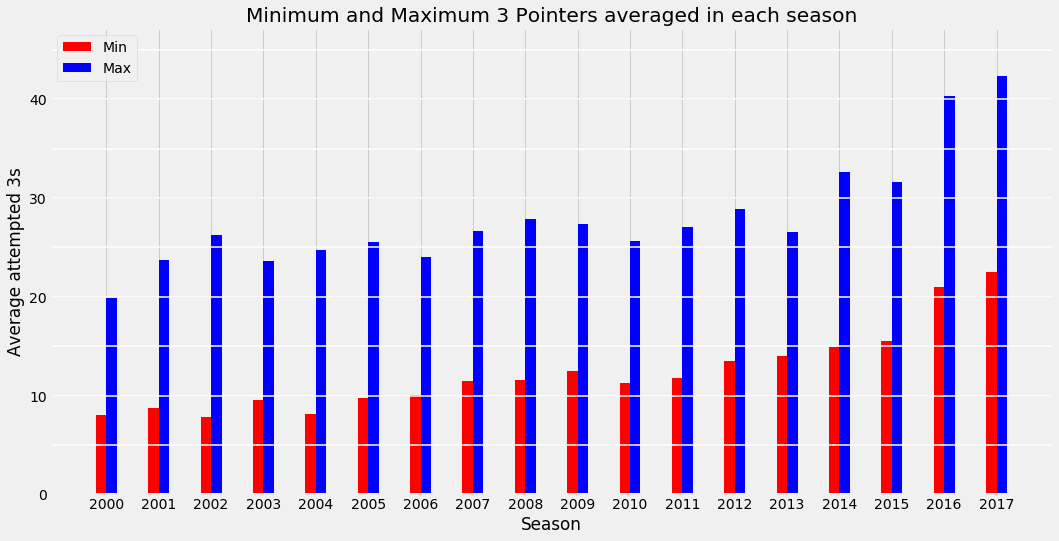

In [26]:
min3s = threes_min_max['min']
max3s = threes_min_max['max']


fig, ax = plt.subplots(figsize = (16,8))

ind = np.arange(2000,2018)    # the x locations for the groups
width = 0.2         # the width of the bars
p1 = ax.bar(ind, min3s, width, color='r')

p2 = ax.bar(ind + width, max3s, width,
            color='b')

ax.set_title('Minimum and Maximum 3 Pointers averaged in each season')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels([x for x in threes_min_max.season])
ax.legend((p1[0], p2[0]), ('Min', 'Max'))

for x in range(0,50,5):
    plt.axhline(y = x, color = 'white', linewidth =1.5)

plt.xlabel('Season')
plt.ylabel('Average attempted 3s')

ax.autoscale_view()

plt.show()

#### Plot the trend of increasing threes over time

We can clearly see from the plots above that there is a shift in the number of 3 pointers teken each year. Let's put this onto a chart the plots the average number of 3's attempted in the league over time to get a clear idea of the trend.


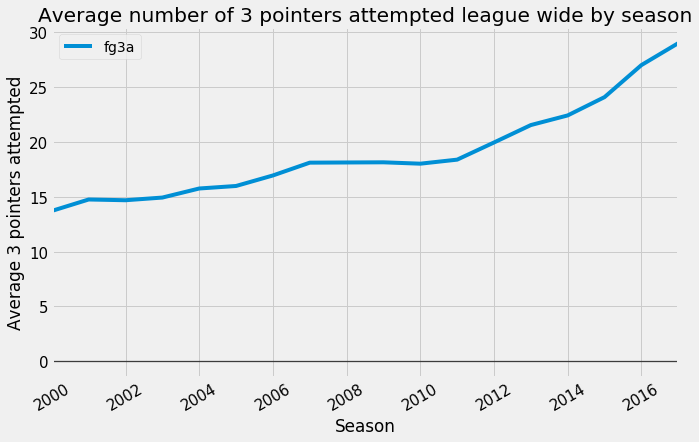

In [27]:
fg3 = league_avgs.plot(x = 'season', y = 'fg3a', figsize = (10,6))
fg3.tick_params(axis = 'both', which = 'major', labelsize = 15)
fg3.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
plt.xticks(x = 'season', rotation=30)
plt.xlabel('Season')
plt.ylabel('Average 3 pointers attempted')
plt.title('Average number of 3 pointers attempted league wide by season')
plt.show()


We can clearly see that since the turn of the century, the amount of three pointers attempted by the league as a whole has basically doubled. It seems as thought things stayed pretty constant for a few years in the middle between 2007 and 2011, but the last 5 years there has been a major jump in 3 pointers taken.

### The relationship between 3 pointers attempted and offensive efficiency

Since we know that teams are attempting more 3 pointers, lets see if that has any effect on offensive efficiency of teams.

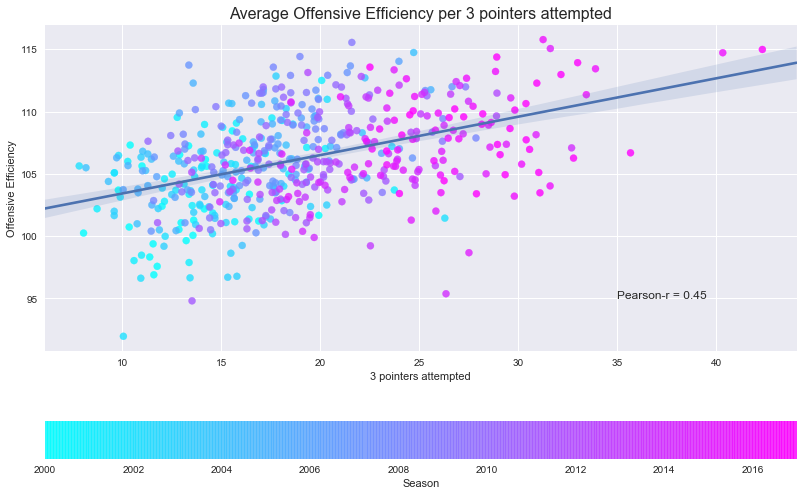

In [28]:
#calculate the pearson correlation between 3 pointers attempted and offensive efficiency
corr = round(stats.pearsonr(team_avgs.fg3a, team_avgs.off_eff)[0],3)

sns.set()
plt.figure(figsize=(12,8))
plt.scatter(team_avgs.fg3a, team_avgs.off_eff, marker = '.',c = team_avgs.season, s = 200, alpha = .8, cmap = 'cool')
sns.regplot('fg3a', 'off_eff', team_avgs, scatter = False)
plt.text(x=35, y=95, s = 'Pearson-r = '+str(corr))
plt.xlabel('3 pointers attempted')
plt.ylabel('Offensive Efficiency')
plt.title('Average Offensive Efficiency per 3 pointers attempted', fontsize = 16)
plt.colorbar(orientation='horizontal').set_label('Season')
plt.show()


This plot shows that generally, the more 3 pointers a team attempts per game, the more efficient their offense is. The positive correlation between these two variables, combined with the knowledge that 3 pointers have become more prevelant year after year, tells us that the average offense of the present is a lot more efficient that the past. This can also be visualized by the gradient in the chart, with the bluer shades showing represents the early 2000's and the purplish-pink dots representing more modern day basketball. 

### Analyzing Pace

The pace of an NBA game is essentially just the number of possesions per 48 minutes. The following plots show the evolution of the pace of play in the league over time. As well as the correlation between pace and offensive efficiency and 3 pointers taken.

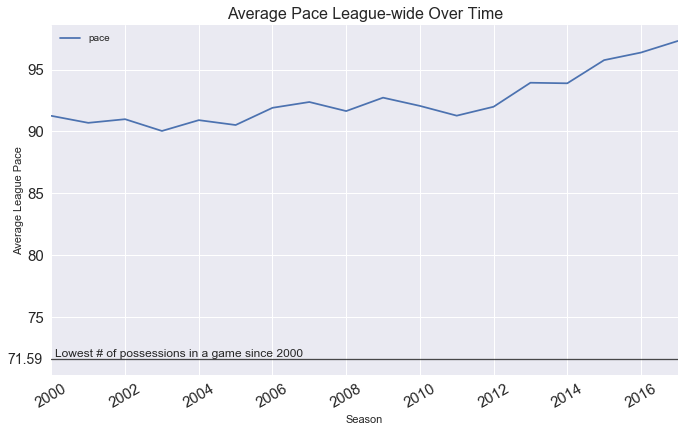

In [29]:
min_poss = round(team_logs.possessions.min(),2)

pace_plt = league_avgs.plot(x = 'season', y = 'pace', figsize = (10,6))
pace_plt.tick_params(axis = 'both', which = 'major', labelsize = 15)

plt.xticks(x = 'season', rotation=30)
plt.axhline(y = min_poss, color = 'black', linewidth = 1.3, alpha = .7)
plt.text(x = 1998.8, y = min_poss-.35, s = str(min_poss), fontsize = 14)
plt.text(x = 2000.1, y = min_poss+.2, s = 'Lowest # of possessions in a game since 2000', fontsize = 12)

plt.ylabel('Average League Pace')
plt.xlabel('Season')
plt.title('Average Pace League-wide Over Time', fontsize = 16)
plt.show()

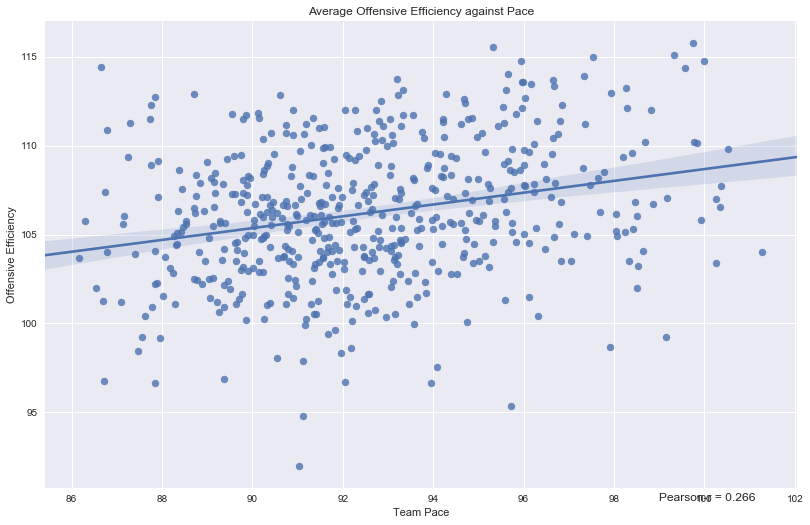

In [30]:
corr = round(stats.pearsonr(team_avgs.pace, team_avgs.off_eff)[0],3)
sns.set()
plt.figure(figsize=(12,8))
plt.scatter(team_avgs.pace, team_avgs.off_eff, marker = '.', s = 200, alpha = .8)
sns.regplot('pace', 'off_eff', team_avgs, scatter = False)
plt.text(x=99, y=90, s = 'Pearson-r = '+str(corr))
plt.xlabel('Team Pace')
plt.ylabel('Offensive Efficiency')
plt.title('Average Offensive Efficiency against Pace')

plt.show()

Offensive efficiency and pace seem to have a slight positive correlation. Increasing the amount of possessions played in a game directly correlating with offensive efficiency is interesting, but this could be caused by faster playing teams take more 3 pointers. Let's take a look at the correlation between pace and 3 point attempts in our next plot.

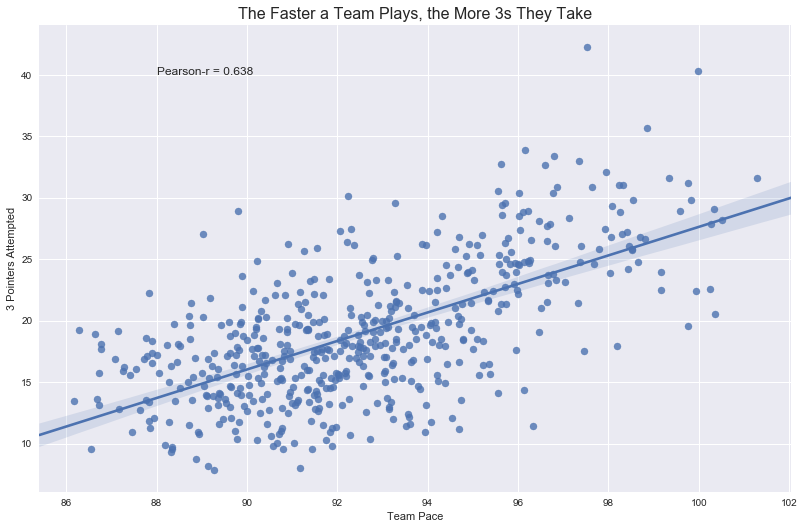

In [31]:
corr = round(stats.pearsonr(team_avgs.pace, team_avgs.fg3a)[0],3)
sns.set()
plt.figure(figsize=(12,8))
plt.scatter(team_avgs.pace, team_avgs.fg3a, marker = '.', s = 200, alpha = .8)
sns.regplot('pace', 'fg3a', team_avgs, scatter = False)
plt.text(x=88, y=40, s = 'Pearson-r = '+str(corr))
plt.xlabel('Team Pace')
plt.ylabel('3 Pointers Attempted')
plt.title('The Faster a Team Plays, the More 3s They Take', fontsize = 16)

plt.show()

## Conclusion

We also saw earlier that the top fantasy scorers tend to play just about 38 minutes a game. There are a varying amount of factors that go into that number however. Less and less players actually play over 38 minutes a games. The number of 3's has lifted offenses throughout the league as well as increased the pace of the game. Players who play on these 3 point focused, run and gun offences will have greater opportunities to The various charts displaying the correlation between team pace and offense or 3 point

Where can we go from here? There a lot of great questions that can still be analyzed from these observations. Is there a limit to how many 3 pointers a team should take before the offensive efficiency starts to come back down? How have defenses faired against these higher octane offenses? Have players who can't shoot a high 3 point percentage become less valuable? The factors are endless, and the stories to be told are too many to fit onto one notebook.

In [32]:
#Values have been changed in the dataset, save modified dataset
plyr_logs.to_csv('player_logs_corrected.csv')